# Fitting granular shear flow of elongated particles with noisy Jeffrey Orbits

In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pickle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools

### Plotting Utilities

In [3]:
# Set the ticks as functions of pi
def pi_formatter(x, pos):
    fractions = {0: '0', np.pi/4: r'$\pi/4$', np.pi/2: r'$\pi/2$', 
                 3*np.pi/4: r'$3\pi/4$', np.pi: r'$\pi$'}
    return fractions.get(x, f'{x/np.pi:.2g}π')

def plot_pdf_and_fit(alpha_values, noise, exponent):

    plt.figure(figsize=(10, 6))
    
    colormap = plt.cm.RdYlBu
    num_colors = len(alpha_values)
    extreme_indices = np.concatenate([
        np.linspace(0, 0.3, num_colors // 2, endpoint=False),  # Lower 30%
        np.linspace(0.7, 1.0, num_colors - num_colors // 2)    # Upper 30%
    ])
    colors = [colormap(i) for i in extreme_indices]
    
    # Insert a unique color for the central aspect ratio
    central_color = 'black'
    central_ap = 1.0  # Replace with the actual central value of aspect ratio
    
    try:
        central_index = alpha_values.index(central_ap)
    except ValueError:  # Raised if central_ap is not in alpha_values
        central_index = 0
    # Insert the central color
    colors.insert(central_index, central_color)
    # Plot the fit results
    for i, alpha in enumerate(alpha_values):
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, optimized_noise, optimized_exponent)
    
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
    
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize = 0.5, label=f"Actual Data (α = {alpha})", color=colors[i])
    
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi/4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title(f'Circular PDF of Angular Distribution ($\\mu_p={cof}$, $I={I}$) and fit Fokker-Planck', fontsize=16)
    plt.grid(True)
    plt.show()

## Solving the jeffrey orbits differential equation

In [4]:
# Define Beta function
def Beta(alpha):
    # return (alpha**2 - 1) / (alpha**2 + 1)
    return (alpha**2 - 1) / (alpha**2 + 1)

# Define f function as in Talbot PRE (2024)
def f(theta_x, alpha):
    return -Gamma / 2 * (1.0 - Beta(alpha) * np.cos(2 * theta_x))

# Define epsilon function
def epsilon_fixed(alpha, noise):
    return noise * alpha**-6 #assuming rotational diffusion goes as power-law

In [5]:
def ode(theta_x, p, alpha, epsilon):
        """Defines the system of ODEs for the solver."""
        dp_dtheta_x = (f(theta_x, alpha) * p[0] + c) / epsilon(alpha)
        return np.array([dp_dtheta_x])

def boundary_conditions(p_start, p_end):
    """Boundary conditions: p(-π/2) == p(π/2)."""
    return np.array([p_start[0] - p_end[0]])

# Solver function for a specific alpha value
def solve_for_alpha(alpha_value, noise):

    epsilon = lambda alpha: epsilon_fixed(alpha, noise) 
    # Define the theta_x range and an initial guess for the solution
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 500)
    initial_guess = np.ones((1, theta_x.size))  # Initial guess for p(θ_x)
    sol = solve_bvp(
        lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon),
        boundary_conditions,
        theta_x,
        initial_guess
    )
    # Normalize the solution
    if sol.success:
        p_values = sol.sol(theta_x)[0]
        integral_value = np.trapezoid(p_values, theta_x)  # Integrate using trapezoidal rule
        normalized_solution = p_values / integral_value
        return theta_x, normalized_solution
    else:
        raise RuntimeError("BVP solver failed to converge")


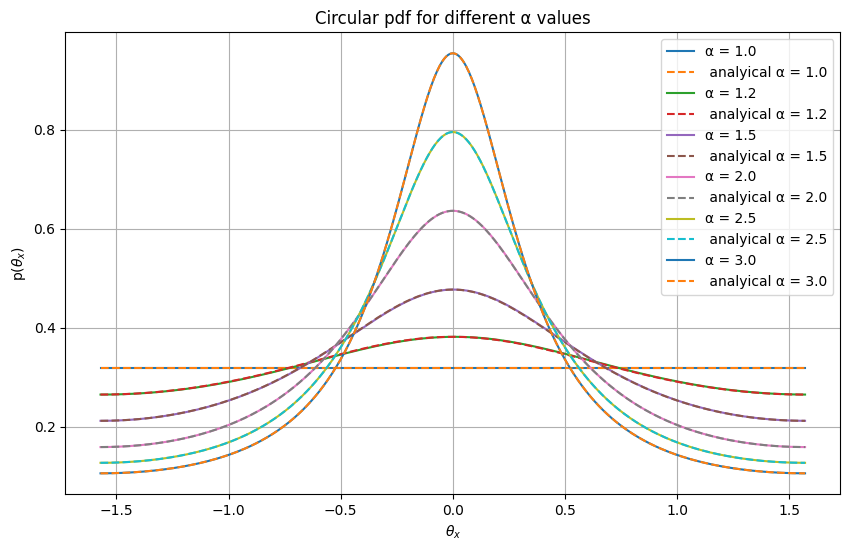

In [6]:
# Constants
Gamma = 1.0
noise = 0.01
c = 1.0  # Constant
alpha_values = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]

# Solve and normalize solutions for each alpha
solutions = []
for alpha in alpha_values:
    theta_x, normalized_solution = solve_for_alpha(alpha, noise)
    solutions.append((alpha, theta_x, normalized_solution))

# Plot each normalized solution as a function of θ_x
plt.figure(figsize=(10, 6))
for alpha, theta_x, normalized_solution in solutions:
    plt.plot(theta_x, normalized_solution, label=f"α = {alpha}")
    no_noise_analytical = alpha/(np.pi*(1+(alpha**2-1)*(np.sin(theta_x)**2)))
    plt.plot(theta_x, no_noise_analytical, label=f" analyical α = {alpha}", linestyle='--')

plt.xlabel("$\\theta_x$")
plt.ylabel("p($\\theta_x$)")
plt.title("Circular pdf for different α values")
plt.legend()
plt.grid(True)
plt.show()

In the small noise limit we recover the exact solution.

## Reading the data from simulations

*change the input directory and the logic to read data from other files*

In [10]:
def read_pdf_theta(directory, fixed_cof, fixed_I, aspect_ratios, direction):
    
    os.chdir(directory)
    #initilize data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                if direction == 'x':
                    pdf_data = file_data.get('pdf_thetax', None)
                elif direction == 'z':
                    pdf_data = file_data.get('pdf_thetaz', None)
                else:
                    raise ValueError("Invalid direction. Choose either 'x' or 'z'.")

                if pdf_data is not None and pdf_data.shape == (180, 2):
                    pdf_values = pdf_data[:, 1]  # The PDF values
                    bin_centers = pdf_data[:, 0]  # The bin centers
                    if ap<1:
                        bin_centers = bin_centers + np.pi/2
                        bin_centers = np.where(bin_centers>np.pi/2, bin_centers-np.pi, bin_centers)
                          # Sort the data to avoid crossing boundaries
                        sorted_indices = np.argsort(bin_centers)
                        bin_centers = bin_centers[sorted_indices]
                        pdf_values = pdf_values[sorted_indices]
                    reshaped_tuple = tuple((bin_centers, pdf_values))
                    actual_data.append(reshaped_tuple)

    return actual_data



def read_data_key(key, directory, fixed_cof, fixed_I, aspect_ratios):
    """
    Read the data from the pickle files with the given key.
    """
    os.chdir(directory)
    # Initialize the data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                # Extract the data
                data = file_data.get(key, None)
                if data is not None:
                    actual_data.append(data)
    return actual_data

## Fitting the data with power-law of rotational diffusion and noise

In [8]:
def epsilon_exponent(alpha, noise, exponent):
    """
    Epsilon function with exponent as a parameter
    """
    return noise * alpha**-exponent

### We define an error function which takes the L_2 norm difference of all the shape at the same time. Threfore we attempt to minimize the difference of the fit, for all values of alpha and just two fitting parameters

In [9]:
def solve_for_alpha_fit(alpha_value, noise, exponent):

    epsilon_with_params = lambda alpha: epsilon_exponent(alpha, noise, exponent)

    # Define the theta_x range and an initial guess for the solution
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 180)
    initial_guess = np.ones((1, theta_x.size))  # Initial guess for p(θ_x)

    sol = solve_bvp(
        lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon_with_params),
        boundary_conditions,
        theta_x,
        initial_guess
    )
    # Normalize the solution
    if sol.success:
        p_values = sol.sol(theta_x)[0]
        integral_value = np.trapezoid(p_values, theta_x)  # Integrate using trapezoidal rule
        normalized_solution = p_values / integral_value
        return theta_x, normalized_solution
    else:
        raise RuntimeError("BVP solver failed to converge")

# Define the error function for optimization
def error_function(params, actual_data, alpha_values):
    noise, exponent = params  # Unpack parameters
    error = 0.0

    # Loop over each alpha value and compare model to data
    for i, alpha in enumerate(alpha_values):
        # Solve the model with the current parameters
        _, model_solution = solve_for_alpha_fit(alpha, noise, exponent)

        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]

        # Interpolate the model solution to the actual data points
        model_interpolated = np.interp(actual_theta_x, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)

        # Compute the squared error
        error += np.sum((actual_p - model_interpolated)**2)

    return error

/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final
True
Optimized Noise: 0.6144645370116012
Optimized Exponent: 2.296961071579435


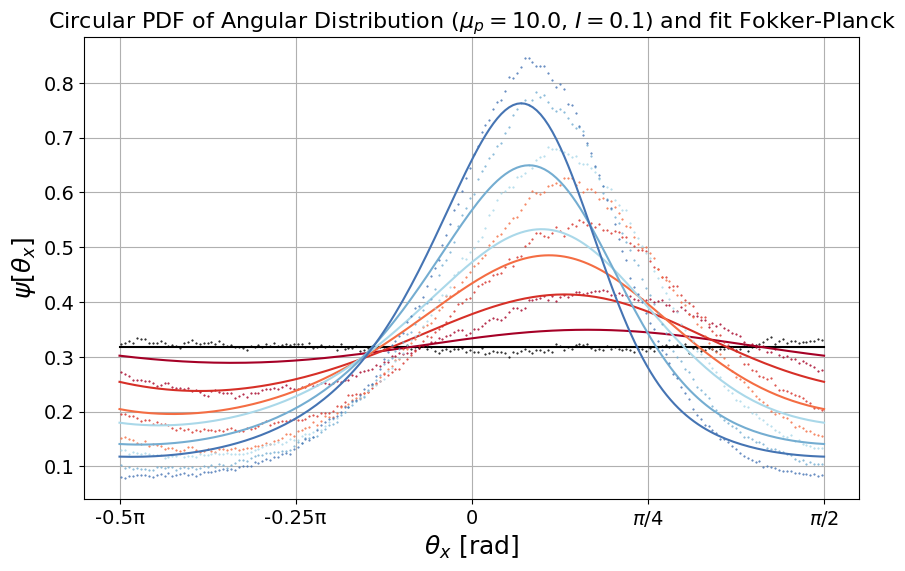

In [10]:
# alpha_values = [0.33, 0.4, 0.5, 0.56, 0.67, 0.83, 1.0] 
alpha_values = [1.0, 1.2, 1.5, 1.8 ,2.0 ,2.5 ,3.0] 
# alpha_values = [1.0, 2.0]
cof = 10.0
I=0.1
# Initial guess for the parameters (noise and exponent)
initial_guess = [1, 2]

# alpha_values = alpha_values[::-1]
# Format: [(theta_x array, p(theta_x) array), ...]
directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final/"
actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
print(os.getcwd())
alpha_values = [1/alpha if alpha <1 else alpha for alpha in alpha_values]  

# Perform the optimization
result = minimize(error_function, initial_guess, args=(actual_data, alpha_values),
                  method='L-BFGS-B', tol = 1e-6, options={'maxiter':10000})

# Extract the optimized parameters
optimized_noise, optimized_exponent = result.x
print(result.success)
print(f"Optimized Noise: {optimized_noise}")
print(f"Optimized Exponent: {optimized_exponent}")

plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)


This simple fit does not seem to work well enough. Underestimation of peak at low alpha and overestimation at high alpha.

Moreover, the solution is extremely sensitive to the initial conditions.

Even a grid search can not find a much better solution

Optimized noise: 0.32105263157894737
Optimized exponent: 1.4736842105263157


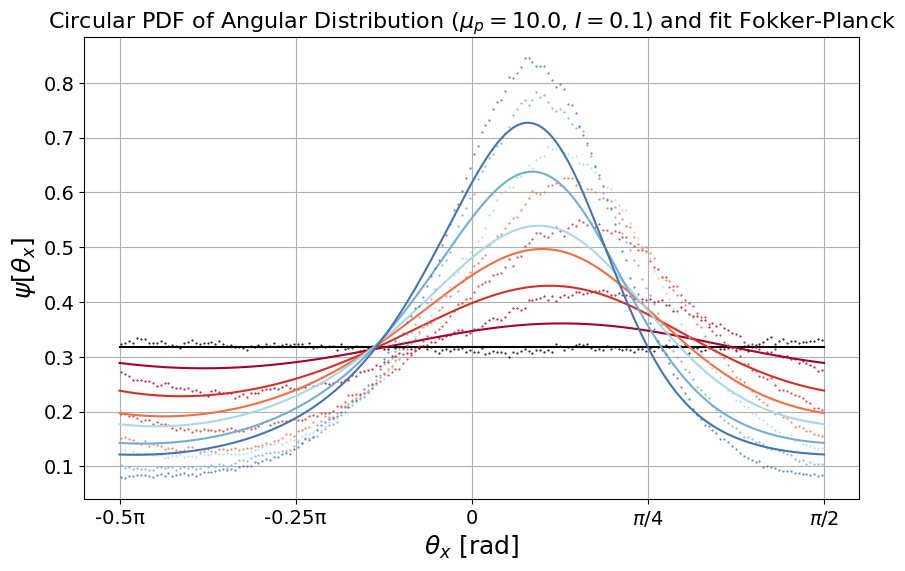

In [11]:
# Define the parameter grid
noise_values = np.linspace(0.1, 1.5, 20)  # Grid for noise
exponent_values = np.linspace(1.0, 2.0, 20)  # Grid for exponent

# Initialize variables to track the best solution
best_error = float('inf')
best_params = None

# Perform grid search
for noise, exponent in itertools.product(noise_values, exponent_values):
    params = [noise, exponent]
    current_error = error_function(params, actual_data, alpha_values)
    
    if current_error < best_error:
        best_error = current_error
        best_params = params

# Extract the optimized parameters
optimized_noise, optimized_exponent = best_params
print("Optimized noise:", optimized_noise)
print("Optimized exponent:", optimized_exponent)
plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

## Fitting data with power-law elongation and noise

Here we try to fix the rotational diffusion with a power-law and fit the elongation alpha of the grains.
The basic idea is that a grain has an "effective shape" 

In [12]:
def epsilon_alpha_squared(alpha, noise):
    return noise * alpha**-6

def solve_for_alpha_fit(alpha_value, noise, factor_alpha):

    alpha_value = alpha_value**factor_alpha
    # alpha_value *= factor_alpha
    # Define the theta_x range and an initial guess for the solution
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 180)
    initial_guess = np.ones((1, theta_x.size))  # Initial guess for p(θ_x)

    epsilon = lambda alpha: epsilon_alpha_squared(alpha, noise)
    
    sol = solve_bvp(
        lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon),
        boundary_conditions,
        theta_x,
        initial_guess
    )
    # Normalize the solution
    if sol.success:
        p_values = sol.sol(theta_x)[0]
        integral_value = np.trapezoid(p_values, theta_x)  # Integrate using trapezoidal rule
        normalized_solution = p_values / integral_value
        return theta_x, normalized_solution
    else:
        raise RuntimeError("BVP solver failed to converge")

# Define the error function for optimization
def error_function(params, actual_data, alpha_values):
    noise, factor_alpha = params  # Unpack parameters
    error = 0.0

    # Loop over each alpha value and compare model to data
    for i, alpha in enumerate(alpha_values):
        # Solve the model with the current parameters
        _, model_solution = solve_for_alpha_fit(alpha, noise, factor_alpha)

        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]

        # Interpolate the model solution to the actual data points
        model_interpolated = np.interp(actual_theta_x, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)

        # Compute the squared error
        error += np.sum((actual_p - model_interpolated)**2)

    return error

In [13]:
# Define the parameter grid
noise_values = np.linspace(0.1, 5, 50)  # Grid for noise
factor_values = np.linspace(0.5, 5, 50)  # Grid for factor

# Initialize variables to track the best solution
best_error = float('inf')
best_params = None

# Perform grid search
for noise, factor in itertools.product(noise_values, factor_values):
    params = [noise, exponent]
    current_error = error_function(params, actual_data, alpha_values)
    
    if current_error < best_error:
        best_error = current_error
        best_params = params

# Extract the optimized parameters
optimized_noise, optimized_factor = best_params
print("Optimized noise:", optimized_noise)
print("Optimized factor:", optimized_factor)
plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

RuntimeError: BVP solver failed to converge

Fitting one shape at a time yields better results, at least for the high inertia and high frictional case

True
Optimized Noise: 2.187018330921924
Optimized Exponent: 0.7430461205888041


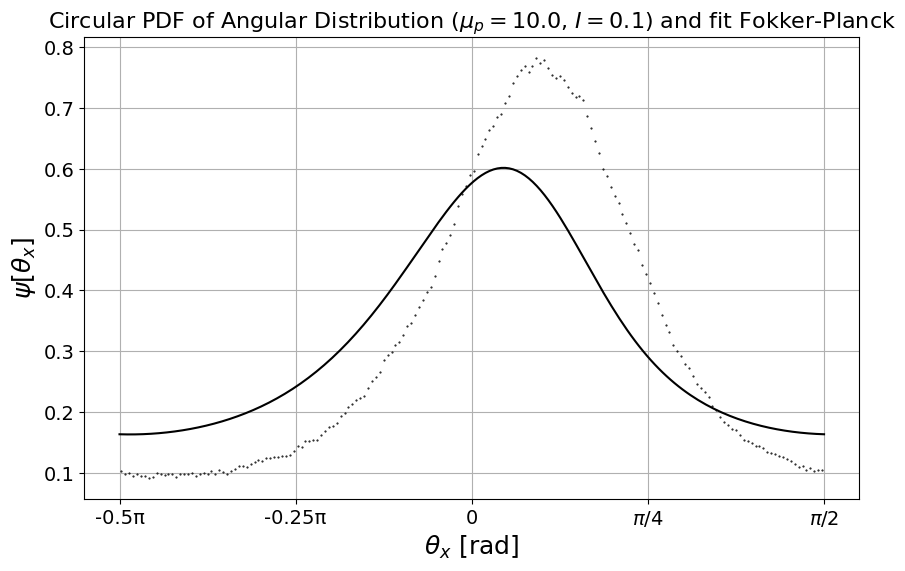

In [14]:
alpha_values = [2.5] 
actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Initialize variables to track the best solution
# Perform the optimization
result = minimize(error_function, initial_guess, args=(actual_data, alpha_values),
                  method='L-BFGS-B', tol = 1e-6, options={'maxiter':10000})

# Extract the optimized parameters
optimized_noise, optimized_exponent = result.x
print(result.success)
print(f"Optimized Noise: {optimized_noise}")
print(f"Optimized Exponent: {optimized_exponent}")

plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

Fitting the distribution with the same exponent, probably does not work on low microscopic frictions

In [15]:
alpha_values = [3.0] 
cof = 0.4
I=0.001
intitial_guess = [1.9, 4]

actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Initialize variables to track the best solution
# Perform the optimization
result = minimize(error_function, initial_guess, args=(actual_data, alpha_values),
                  method='L-BFGS-B', tol = 1e-6, options={'maxiter':10000})

# Extract the optimized parameters
optimized_noise, optimized_exponent = result.x
print(result.success)
print(f"Optimized Noise: {optimized_noise}")
print(f"Optimized Exponent: {optimized_exponent}")

plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

RuntimeError: BVP solver failed to converge

In [25]:
from scipy.optimize import curve_fit
# Define the model function for curve_fit
def model(thetax, noise, exponent, alpha):
    # Solve the BVP for the given parameters
    _, model_solution = solve_for_alpha_fit(alpha, noise, exponent)
    # Interpolate the solution at the given theta_x values
    interpolated_solution = np.interp(thetax, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)
    return interpolated_solution


# Loop over each alpha value and fit noise and exponent
optimized_params = []
for i, alpha in enumerate(alpha_values):
    actual_theta_x, actual_p = actual_data[i]  # Extract data for this alpha
    
    # Wrap the model to pass the fixed alpha value
    def fixed_alpha_model(thetax, noise, exponent):
        return model(thetax, noise, exponent, alpha)
    
    # Perform the curve fitting
    initial_guess = [1.0, 1.0]  # Example initial guesses for noise and exponent
    popt, pcov = curve_fit(fixed_alpha_model, actual_theta_x, actual_p, p0=initial_guess)
    
    # Store the optimized parameters
    optimized_params.append({'alpha': alpha, 'noise': popt[0], 'exponent': popt[1]})

cof = 10.0
I=0.001
alpha_values = [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]
intitial_guess = [4, 2]

actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Print or analyze the results
for result in optimized_params:
    print(f"Alpha: {result['alpha']}, Noise: {result['noise']}, Exponent: {result['exponent']}")

# Plot function
def plot_actual_and_fits(alpha_values, actual_data, optimized_params):
    plt.figure(figsize=(12, 8))
    
    colormap = plt.cm.viridis
    num_colors = len(alpha_values)
    colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]
    
    # Loop over each alpha value
    for i, result in enumerate(optimized_params):
        alpha = result['alpha']
        noise = result['noise']
        exponent = result['exponent']
        
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, noise, exponent)
        
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
        
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize=4, label=f"Data (α = {alpha:.2f})", color=colors[i])
        
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha:.2f})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title('Circular PDF of Angular Distribution and Fits', fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()

# Example call to the function
plot_actual_and_fits(alpha_values, actual_data, optimized_params)

TypeError: ode() missing 1 required positional argument: 'S'

In [51]:
from scipy.optimize import curve_fit
# Define the model function for curve_fit
def model(thetax, exponent, alpha):
    # Solve the BVP for the given parameters
    _, model_solution = solve_for_alpha_fit(alpha, exponent)
    # Interpolate the solution at the given theta_x values
    interpolated_solution = np.interp(thetax, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)
    return interpolated_solution

# Loop over each alpha value and fit noise and exponent
optimized_params = []
for i, alpha in enumerate(alpha_values):
    actual_theta_x, actual_p = actual_data[i]  # Extract data for this alpha
    
    # Wrap the model to pass the fixed alpha value
    def fixed_alpha_model(thetax,exponent):
        return model(thetax, exponent, alpha)
    
    # Perform the curve fitting
    initial_guess = [3.0]  # Example initial guesses for noise and exponent
    popt, pcov = curve_fit(fixed_alpha_model, actual_theta_x, actual_p, p0=initial_guess)
    
    # Store the optimized parameters
    optimized_params.append({'alpha': alpha, 'exponent': popt[0]})

cof = 10.0
I=0.1
intitial_guess = [3]

actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Print or analyze the results
for result in optimized_params:
    print(f"Alpha: {result['alpha']}, Exponent: {result['exponent']}")

# Plot function
def plot_actual_and_fits(alpha_values, actual_data, optimized_params):
    plt.figure(figsize=(12, 8))
    
    colormap = plt.cm.viridis
    num_colors = len(alpha_values)
    colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]
    
    # Loop over each alpha value
    for i, result in enumerate(optimized_params):
        alpha = result['alpha']
        exponent = result['exponent']
        
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, exponent)
        
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
        
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize=4, label=f"Data (α = {alpha:.2f})", color=colors[i])
        
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha:.2f})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title('Circular PDF of Angular Distribution and Fits', fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()

# Example call to the function
plot_actual_and_fits(alpha_values, actual_data, optimized_params)

ValueError: too many values to unpack (expected 2)

/tmp/ipykernel_5802/987269504.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(p_values * np.cos(2 * theta_x), theta_x)


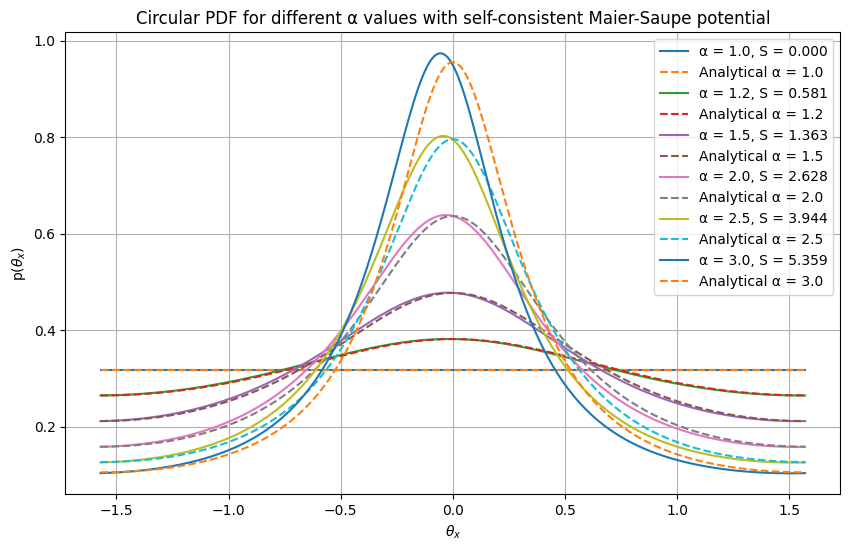

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Constants
Gamma = 1.0
noise = 0.01
c = 1.0  # Constant
alpha_values = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]

# Define Beta function
def Beta(alpha):
    return (alpha**2 - 1) / (alpha**2 + 1)

# Define f function as in Talbot PRE (2024)
def f(theta_x, alpha):
    return -Gamma / 2 * (1.0 - Beta(alpha) * np.cos(2 * theta_x))

# Define epsilon function
def epsilon_fixed(alpha, noise):
    return noise * alpha**-2  # assuming rotational diffusion goes as power-law

# Compute nematic order parameter S
def compute_S(theta_x, p_values):
    return np.trapz(p_values * np.cos(2 * theta_x), theta_x)

# Define ODE with self-consistent Maier-Saupe potential
def ode(theta_x, p, alpha, epsilon, S):
    dp_dtheta_x = (f(theta_x, alpha) * p[0] + c - noise * S * np.sin(2 * theta_x) * p[0]) / epsilon(alpha)
    return np.array([dp_dtheta_x])

# Boundary conditions: p(-π/2) == p(π/2)
def boundary_conditions(p_start, p_end):
    return np.array([p_start[0] - p_end[0]])

def solve_for_alpha(alpha_value, noise, tol=1e-6, max_iter=100):
    """Solve for p(θ_x) with a self-consistent nematic parameter S."""
    
    epsilon = lambda alpha: epsilon_fixed(alpha, noise) 
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 500)
    p_values = np.ones(theta_x.size).reshape(1, -1)  # Fix: Reshape to (1, N)

    # Initialize S
    S_old = 0.0  
    for iteration in range(max_iter):
        sol = solve_bvp(
            lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon, S_old),
            boundary_conditions,
            theta_x,
            p_values
        )
        
        if not sol.success:
            raise RuntimeError("BVP solver failed to converge")

        # Compute new S
        p_values = sol.sol(theta_x)[0].reshape(1, -1)  # Fix: Ensure it remains (1, N)
        S_new = compute_S(theta_x, p_values[0])

        # Check for convergence
        if abs(S_new - S_old) < tol:
            break
        S_old = S_new  # Update S

    # Normalize the solution
    integral_value = np.trapezoid(p_values[0], theta_x)
    normalized_solution = p_values[0] / integral_value
    return theta_x, normalized_solution, S_new

# Solve and normalize solutions for each alpha
solutions = []
for alpha in alpha_values:
    theta_x, normalized_solution, S_final = solve_for_alpha(alpha, noise)
    solutions.append((alpha, theta_x, normalized_solution, S_final))

# Plot each normalized solution as a function of θ_x
plt.figure(figsize=(10, 6))
for alpha, theta_x, normalized_solution, S_final in solutions:
    plt.plot(theta_x, normalized_solution, label=f"α = {alpha}, S = {S_final:.3f}")
    no_noise_analytical = alpha / (np.pi * (1 + (alpha**2 - 1) * (np.sin(theta_x)**2)))
    plt.plot(theta_x, no_noise_analytical, label=f"Analytical α = {alpha}", linestyle='--')

plt.xlabel("$\\theta_x$")
plt.ylabel("p($\\theta_x$)")
plt.title("Circular PDF for different α values with self-consistent Maier-Saupe potential")
plt.legend()
plt.grid(True)
plt.show()


Alpha: 1.0, r: -0.020840843747222282, theta_d: 0.44781789596726873, U: 2.0001085832269556
g(r) is 1.0002171880708752
beta*r/U is -0.0
The predicted theta is nan
Alpha: 1.2, r: 0.7929449103824258, theta_d: 0.7317808716715012, U: 2.1532275966016883
g(r) is 1.3536777267187474
beta*r/U is 0.06640731617611612
The predicted theta is nan
Alpha: 1.5, r: 1.8334660376473746, theta_d: 0.6496258566282564, U: 2.74290322967241
g(r) is 4.13858209161426
beta*r/U is 0.2570922800412507
The predicted theta is nan
Alpha: 1.8, r: 3.114807144022076, theta_d: 0.5682770282680348, U: 3.8072417309819166
g(r) is 28.718662141504794
beta*r/U is 0.43221802224705913
The predicted theta is nan
Alpha: 2.0, r: 4.002910093123798, theta_d: 0.5237710036512402, U: 4.634959039619613
g(r) is 128.37706821867695
beta*r/U is 0.5181806430961229
The predicted theta is nan
Alpha: 2.5, r: 6.544529513581927, theta_d: 0.4308274351436857, U: 7.113106206080615
g(r) is 12262.61791617879
beta*r/U is 0.6662549277709486
The predicted theta

/tmp/ipykernel_7830/3202531757.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))
/tmp/ipykernel_7830/3202531757.py:54: RuntimeWarning: invalid value encountered in arccos
  predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))


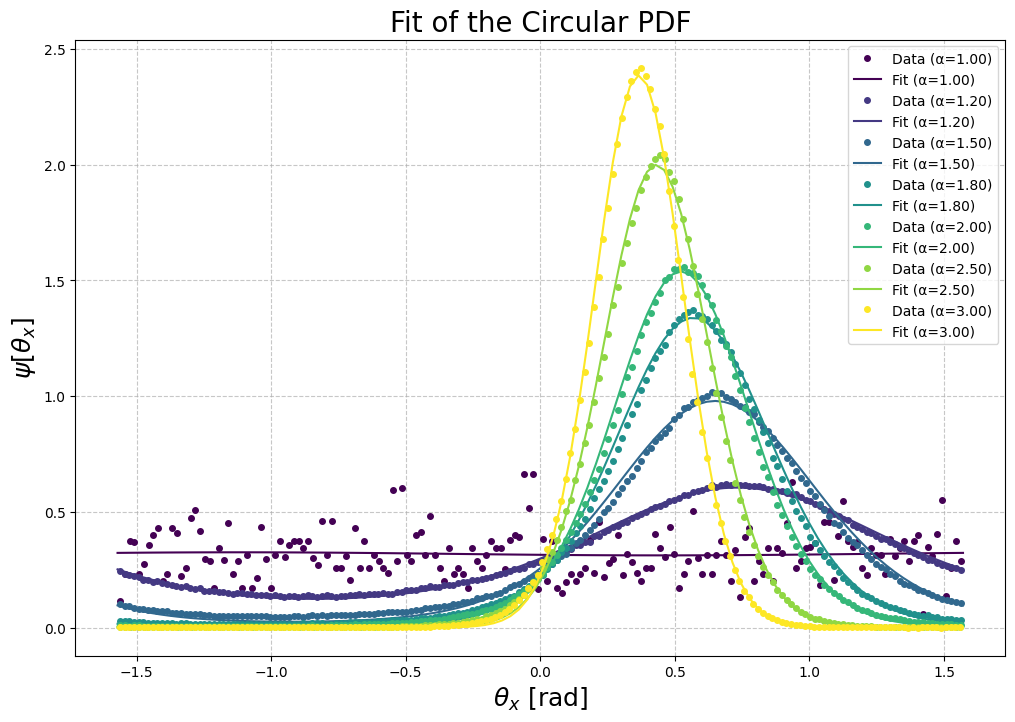

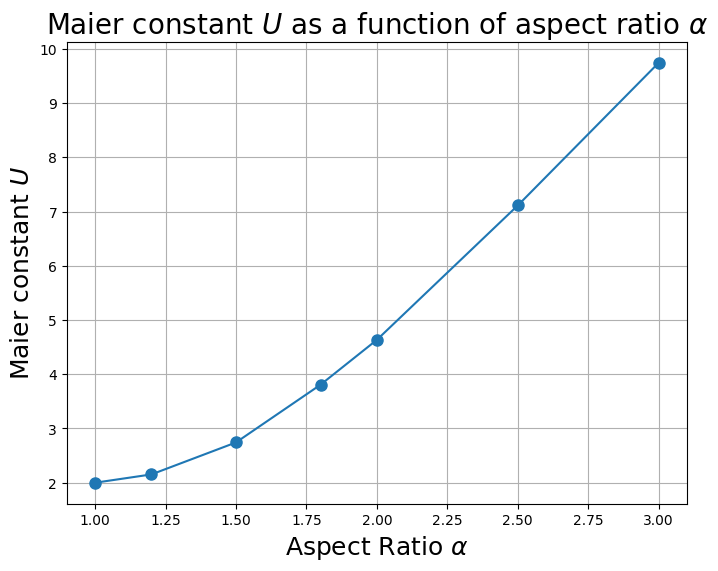

In [13]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt

# Define the function to fit
def fit_function(x, r, theta_d):
    """ Model function with r and theta_d as parameters. """
    numerator = np.exp(r * np.cos(2 * (x - theta_d)))
    
    # Compute denominator numerically
    denominator, _ = spi.quad(lambda t: np.exp(r * np.cos(2 * (t - theta_d))), -np.pi/2, np.pi/2)
    
    return numerator / denominator

cof = 0.0
I=0.1
intitial_guess = [3]
alpha_values = [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]

directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final/"

actual_data = read_pdf_theta(directory, cof, I, alpha_values, 'x')
phis = read_data_key('phi', directory, cof, I, alpha_values)
# Optimize r and theta_d for each alpha value
optimized_params = []
for i, alpha in enumerate(alpha_values):
    actual_x, actual_p = actual_data[i]  # Extract data for this alpha
    
    # Perform the curve fitting
    initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
    popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)
    
    r = popt[0]
    theta_d = popt[1]
    x_fit = np.linspace(-np.pi/2, np.pi/2, 500)
    y_fit = fit_function(x_fit, r, theta_d)
    U = r / np.trapezoid(np.cos(2 * (x_fit - theta_d)) * y_fit, x_fit) 
    # Store the optimized parameters
    optimized_params.append({'alpha': alpha, 'r': r, 'theta_d': theta_d, 'U': U})
    # N_fact = 1/np.pi*np.trapezoid(np.sin(actual_x)*np.exp(r*np.sin(actual_x)), actual_x)
    # M_fact = 1/np.pi*np.trapezoid(np.exp(r*np.sin(actual_x)), actual_x) 
    # factor = (M_fact-1/M_fact)/N_fact
    # print(f"factor: {factor}")
    # expected_theta_d = np.arccos(factor)/2
    print(f"Alpha: {alpha}, r: {r}, theta_d: {theta_d}, U: {U}")
    g_r = (np.trapezoid(np.exp(r*np.cos(2*x_fit)), x_fit)/np.pi)**2
    print(f"g(r) is {g_r}")
    # if alpha > 1:
    beta = (alpha**2-1)/(alpha**2+1)

    print(f"beta*r/U is {beta*r/U}")
    # print(f"beta is {beta}")
    predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))
    print(f"The predicted theta is {predicted_theta}")

# Plot the actual data and fits
plt.figure(figsize=(12, 8))
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, len(alpha_values))]

for i, result in enumerate(optimized_params):
    alpha = result['alpha']
    r = result['r']
    theta_d = result['theta_d']
    
    # Generate model predictions
    x_fit = np.linspace(-np.pi/2, np.pi/2, 100)
    y_fit = fit_function(x_fit, r, theta_d)
    
    # Plot actual data
    actual_x, actual_p = actual_data[i]
    plt.plot(actual_x, actual_p, 'o', markersize=4, label=f"Data (α={alpha:.2f})", color=colors[i])
    
    # Plot fitted function
    plt.plot(x_fit, y_fit, '-', label=f"Fit (α={alpha:.2f})", color=colors[i])

plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
plt.title('Fit of the Circular PDF', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()

# plot U as a function of alpha
alphas = [result['alpha'] for result in optimized_params]
Us = [result['U'] for result in optimized_params]

plt.figure(figsize=(8, 6))
plt.plot(alphas, Us, 'o-', markersize=8)
plt.xlabel('Aspect Ratio $\\alpha$', fontsize=18)
plt.ylabel('Maier constant $U$', fontsize=18)
plt.title('Maier constant $U$ as a function of aspect ratio $\\alpha$', fontsize=20)
plt.grid(True)
plt.show()



Processing cof = 0.0


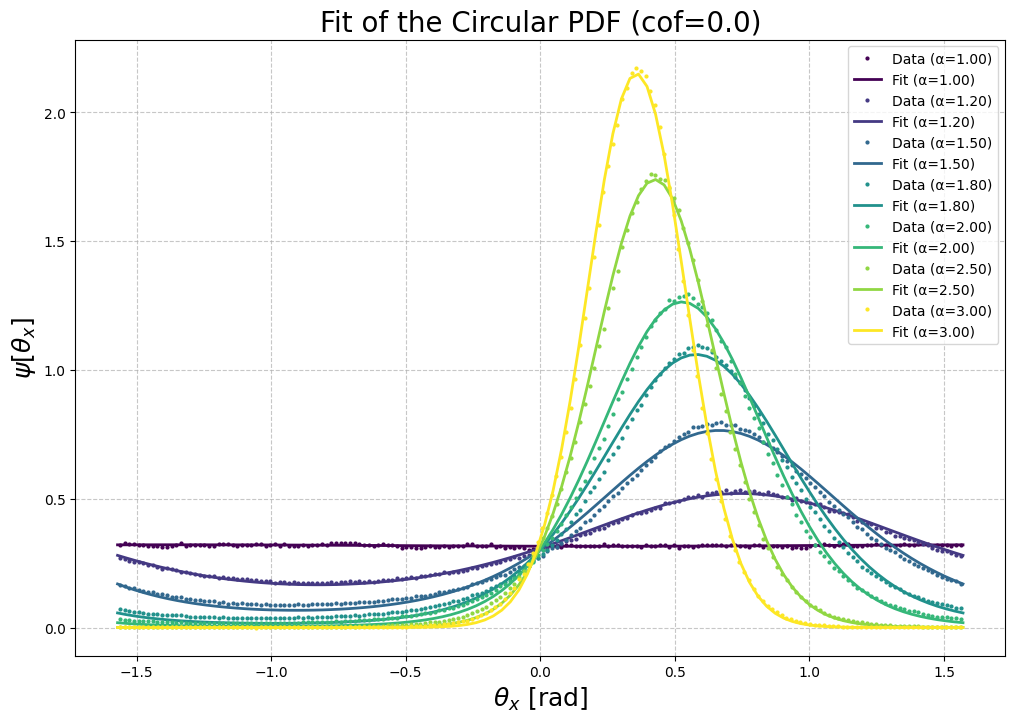

Processing cof = 0.001


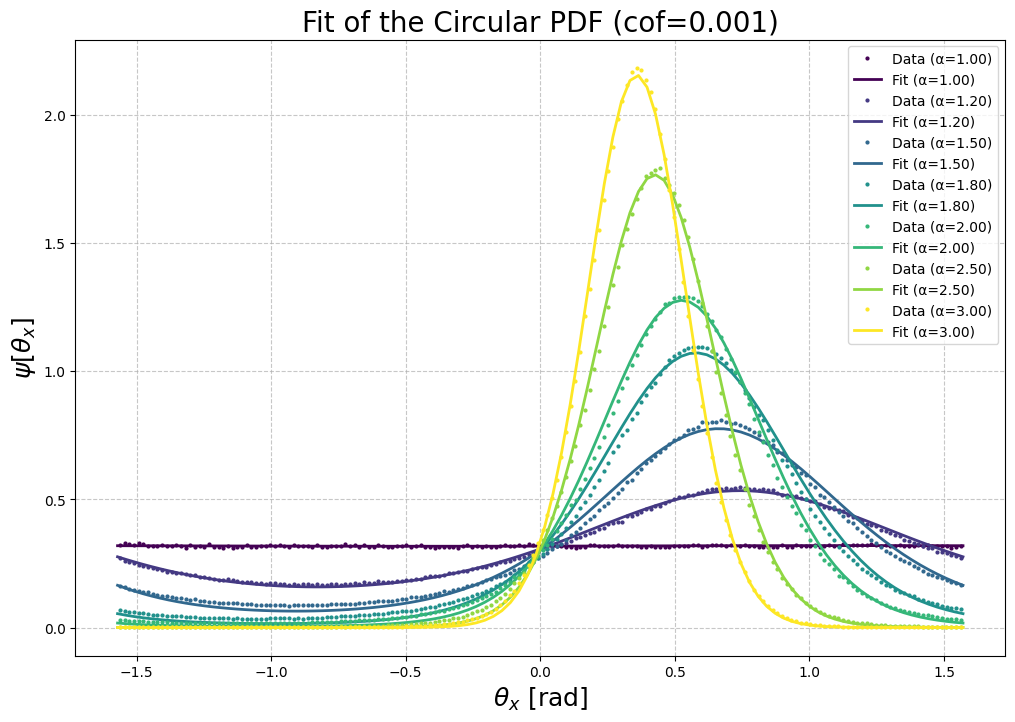

Processing cof = 0.01


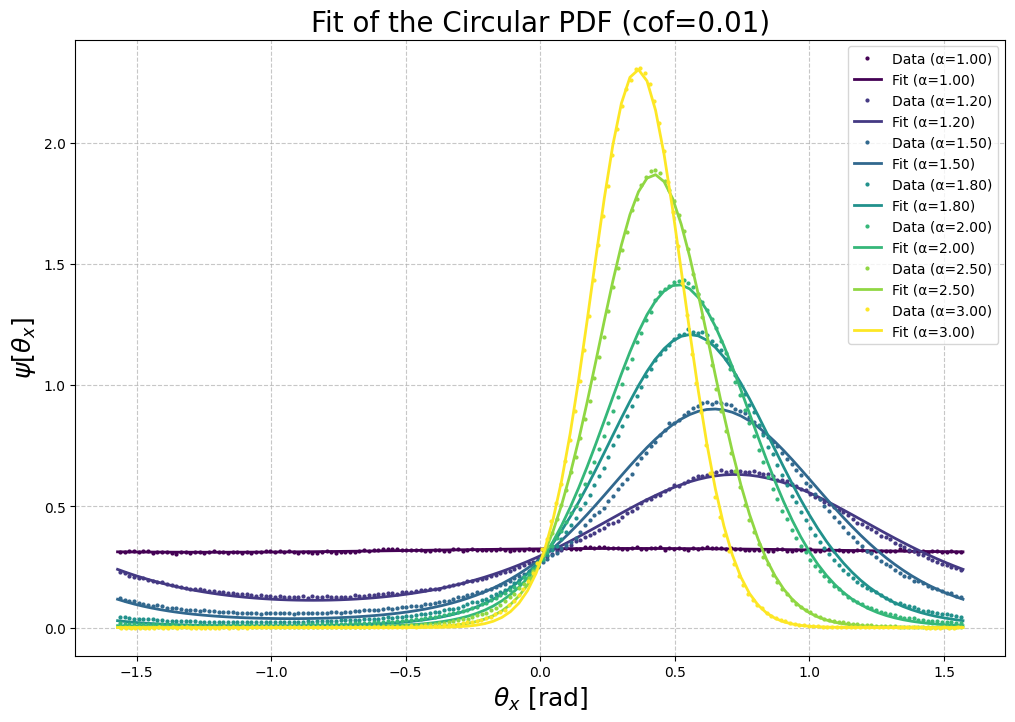

Processing cof = 0.1


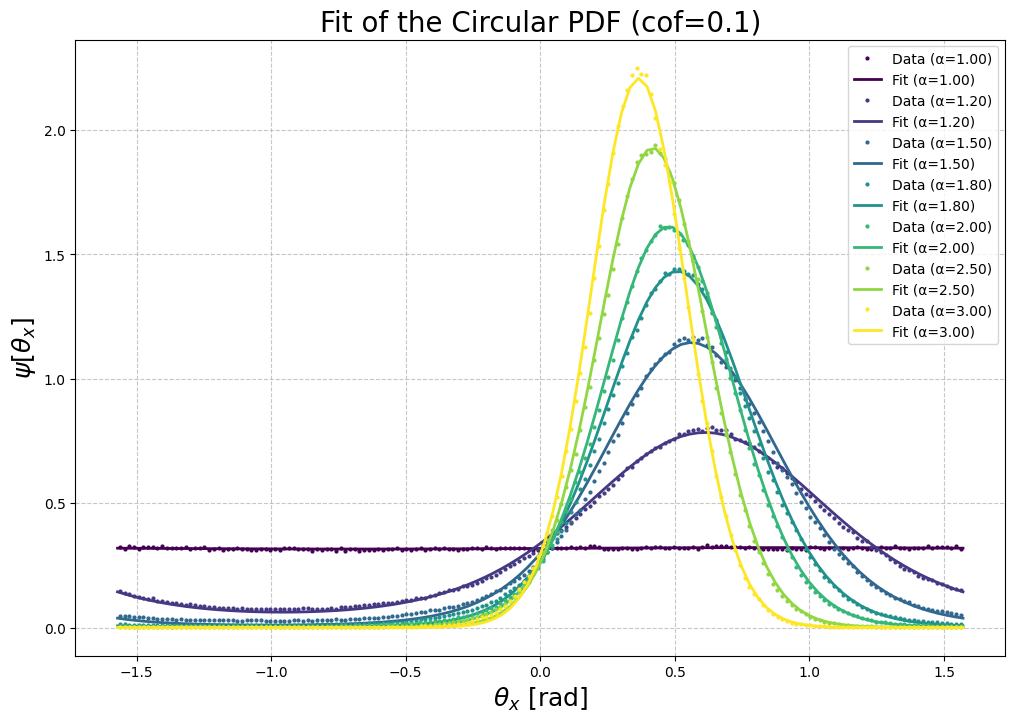

Processing cof = 0.4


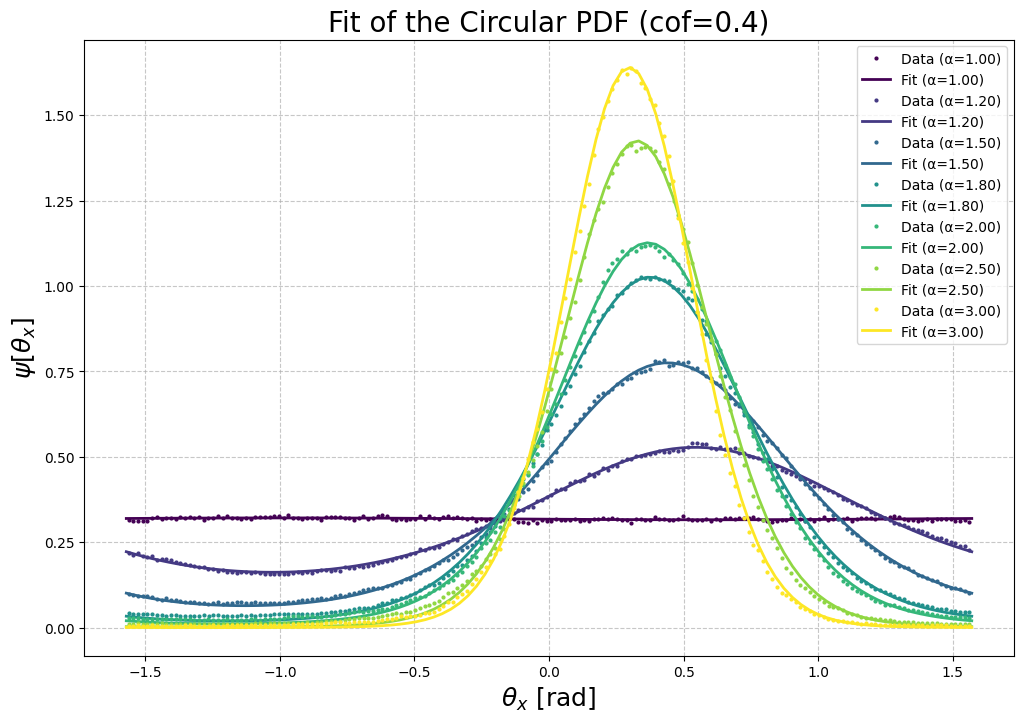

Processing cof = 1.0


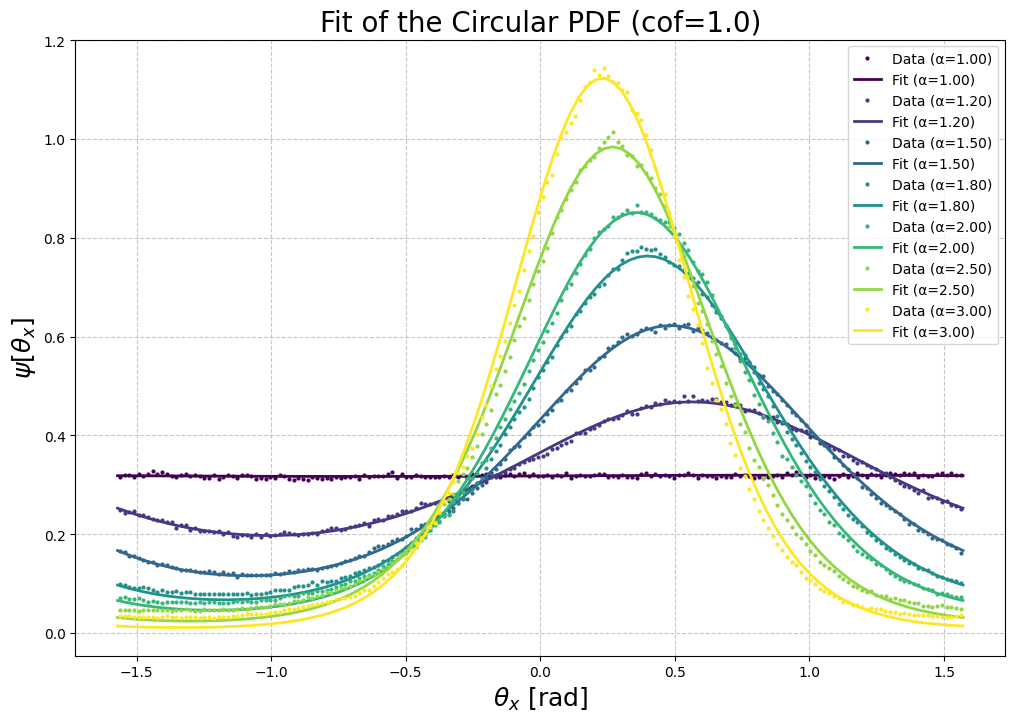

Processing cof = 10.0


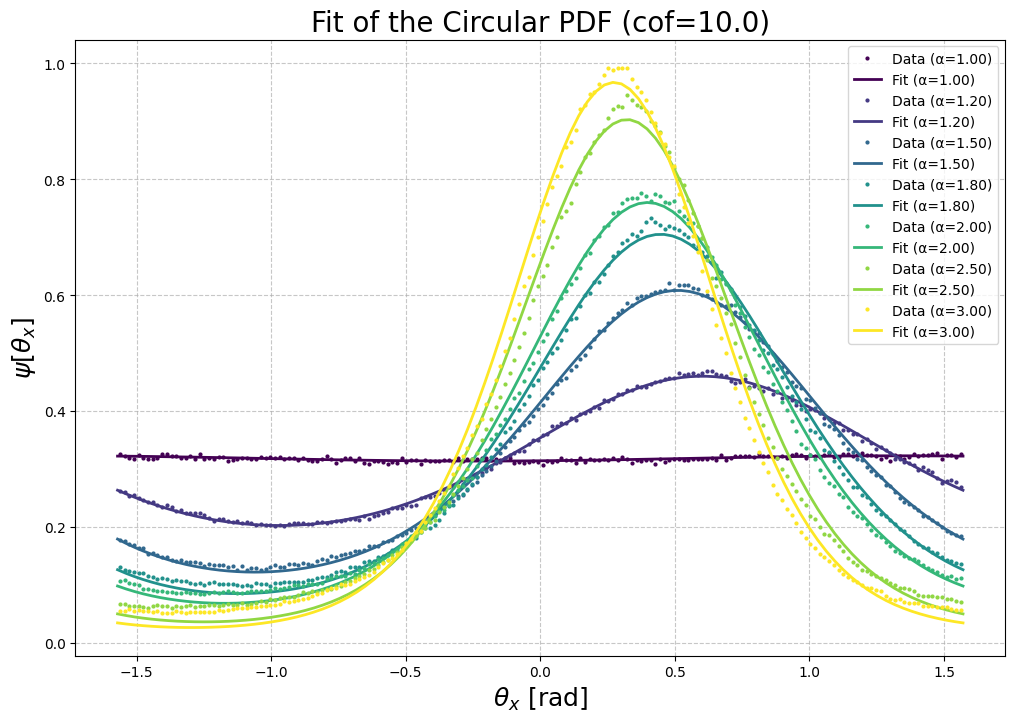

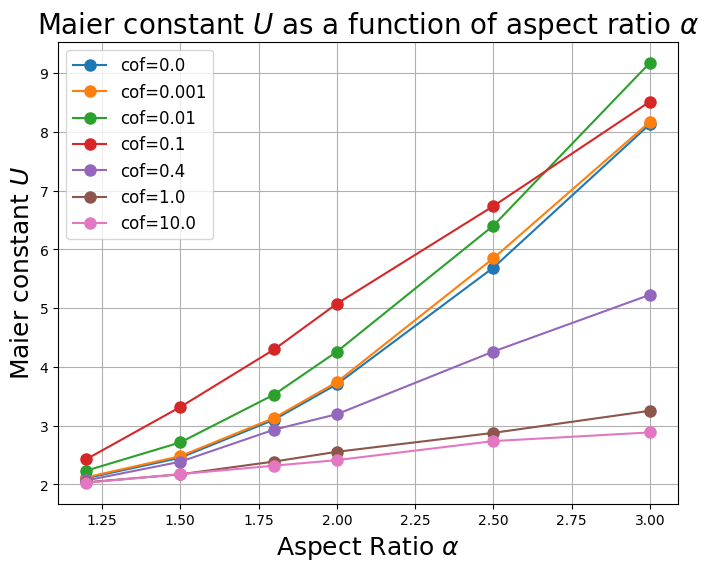

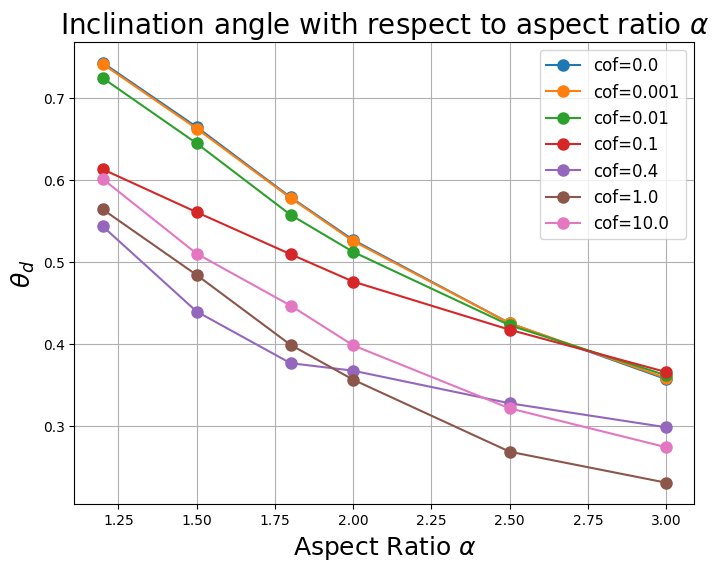

In [3]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt

from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pickle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools

# Define the function to fit
def fit_function(x, r, theta_d):
    """ Model function with r and theta_d as parameters. """
    numerator = np.exp(r * np.cos(2 * (x - theta_d)))
    
    # Compute denominator numerically
    denominator, _ = spi.quad(lambda t: np.exp(r * np.cos(2 * (t - theta_d))), -np.pi/2, np.pi/2)
    
    return numerator / denominator

# Define the values of cof to loop over
cofs = [0.0, 0.001, 0.01, 0.1, 0.4, 1.0, 10.0]
Is = [0.1, 0.046, 0.022, 0.01, 0.0046, 0.0022, 0.001]
alpha_values = [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]

# Dictionary to store results for each cof
all_results = {}

# Loop over cof values
for cof in cofs:
    print(f"Processing cof = {cof}")

    actual_data = read_pdf_thetax(directory, cof, I, alpha_values)

    optimized_params = []

    # Optimize r and theta_d for each alpha
    for i, alpha in enumerate(alpha_values):
        actual_x, actual_p = actual_data[i]  # Extract data for this alpha
        
        # Perform the curve fitting
        initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
        popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)
        
        r = popt[0]
        theta_d = popt[1]
        U = r / np.trapezoid(np.cos(2 * (actual_x - theta_d)) * actual_p, actual_x)

        # Store results
        optimized_params.append({'alpha': alpha, 'r': r, 'theta_d': theta_d, 'U': U})

    # Store results for this cof
    all_results[cof] = optimized_params

    # Plot the actual data and fits for this cof
    plt.figure(figsize=(12, 8))
    colormap = plt.cm.viridis
    colors = [colormap(i) for i in np.linspace(0, 1, len(alpha_values))]

    for i, result in enumerate(optimized_params):
        alpha = result['alpha']
        r = result['r']
        theta_d = result['theta_d']
        
        # Generate model predictions
        x_fit = np.linspace(-np.pi/2, np.pi/2, 100)
        y_fit = fit_function(x_fit, r, theta_d)
        
        # Plot actual data
        actual_x, actual_p = actual_data[i]
        plt.plot(actual_x, actual_p, 'o', markersize=2, label=f"Data (α={alpha:.2f})", color=colors[i])
        
        # Plot fitted function
        plt.plot(x_fit, y_fit, '-', label=f"Fit (α={alpha:.2f})", color=colors[i], linewidth=2)

    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.title(f'Fit of the Circular PDF (cof={cof})', fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()

# Plot U vs alpha for all cofs in a single plot
plt.figure(figsize=(8, 6))

for cof, results in all_results.items():
    alphas = [result['alpha'] for result in results]
    Us = [result['U'] for result in results]
    plt.plot(alphas[1:], Us[1:], 'o-', markersize=8, label=f"cof={cof}")

plt.xlabel('Aspect Ratio $\\alpha$', fontsize=18)
plt.ylabel('Maier constant $U$', fontsize=18)
plt.title('Maier constant $U$ as a function of aspect ratio $\\alpha$', fontsize=20)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))

for cof, results in all_results.items():
    alphas = [result['alpha'] for result in results]
    theta_d = [result['theta_d'] for result in results]
    plt.plot(alphas[1:], theta_d[1:], 'o-', markersize=8, label=f"cof={cof}")

plt.xlabel('Aspect Ratio $\\alpha$', fontsize=18)
plt.ylabel('$\\theta_d$', fontsize=18)
plt.title('Inclination angle with respect to aspect ratio $\\alpha$', fontsize=20)
# plt.xlim(1.1, 3.1)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [1]:
# Set the ticks as functions of pi
def pi_formatter(x, pos):
    fractions = {0: '0', np.pi/4: r'$\pi/4$', np.pi/2: r'$\pi/2$', 
                 3*np.pi/4: r'$3\pi/4$', np.pi: r'$\pi$'}
    return fractions.get(x, f'{x/np.pi:.2g}π')

def plot_pdf_and_fit(alpha_values, noise, exponent):

    plt.figure(figsize=(10, 6))
    
    colormap = plt.cm.RdYlBu
    num_colors = len(alpha_values)
    extreme_indices = np.concatenate([
        np.linspace(0, 0.3, num_colors // 2, endpoint=False),  # Lower 30%
        np.linspace(0.7, 1.0, num_colors - num_colors // 2)    # Upper 30%
    ])
    colors = [colormap(i) for i in extreme_indices]
    
    # Insert a unique color for the central aspect ratio
    central_color = 'black'
    central_ap = 1.0  # Replace with the actual central value of aspect ratio
    
    try:
        central_index = alpha_values.index(central_ap)
    except ValueError:  # Raised if central_ap is not in alpha_values
        central_index = 0
    # Insert the central color
    colors.insert(central_index, central_color)
    # Plot the fit results
    for i, alpha in enumerate(alpha_values):
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, optimized_noise, optimized_exponent)
    
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
    
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize = 0.5, label=f"Actual Data (α = {alpha})", color=colors[i])
    
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi/4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title(f'Circular PDF of Angular Distribution ($\\mu_p={cof}$, $I={I}$) and fit Fokker-Planck', fontsize=16)
    plt.grid(True)
    plt.show()


# read the data
def read_pdf_thetax(directory, fixed_cof, fixed_I, aspect_ratios):
    
    os.chdir(directory)
    #initilize data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                
                # Extract the PDF data
                pdf_data = file_data.get('pdf_thetax', None)
                
                if pdf_data is not None and pdf_data.shape == (180, 2):
                    pdf_values = pdf_data[:, 1]  # The PDF values
                    bin_centers = pdf_data[:, 0]  # The bin centers
                    if ap<1:
                        bin_centers = bin_centers + np.pi/2
                        bin_centers = np.where(bin_centers>np.pi/2, bin_centers-np.pi, bin_centers)
                          # Sort the data to avoid crossing boundaries
                        sorted_indices = np.argsort(bin_centers)
                        bin_centers = bin_centers[sorted_indices]
                        pdf_values = pdf_values[sorted_indices]
                    reshaped_tuple = tuple((bin_centers, pdf_values))
                    actual_data.append(reshaped_tuple)

    return actual_data

def read_data_key(key, directory, fixed_cof, fixed_I, aspect_ratios):
    """
    Read the data from the pickle files with the given key.
    """
    os.chdir(directory)
    # Initialize the data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                # Extract the data
                data = file_data.get(key, None)
                if data is not None:
                    actual_data.append(data)
    return actual_data

/tmp/ipykernel_9881/2595392116.py:61: RuntimeWarning: invalid value encountered in arccos
  predicted_theta = 0.5 * np.arccos(U / (r * beta) * (1 - 1 / g_r))


predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


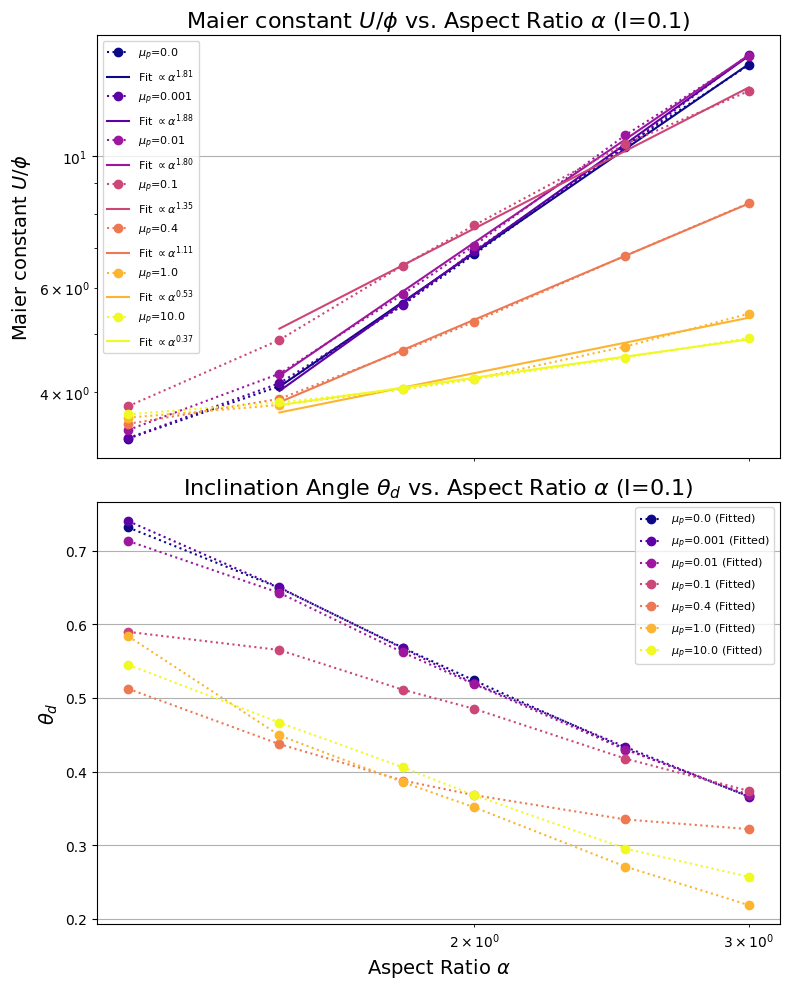

predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


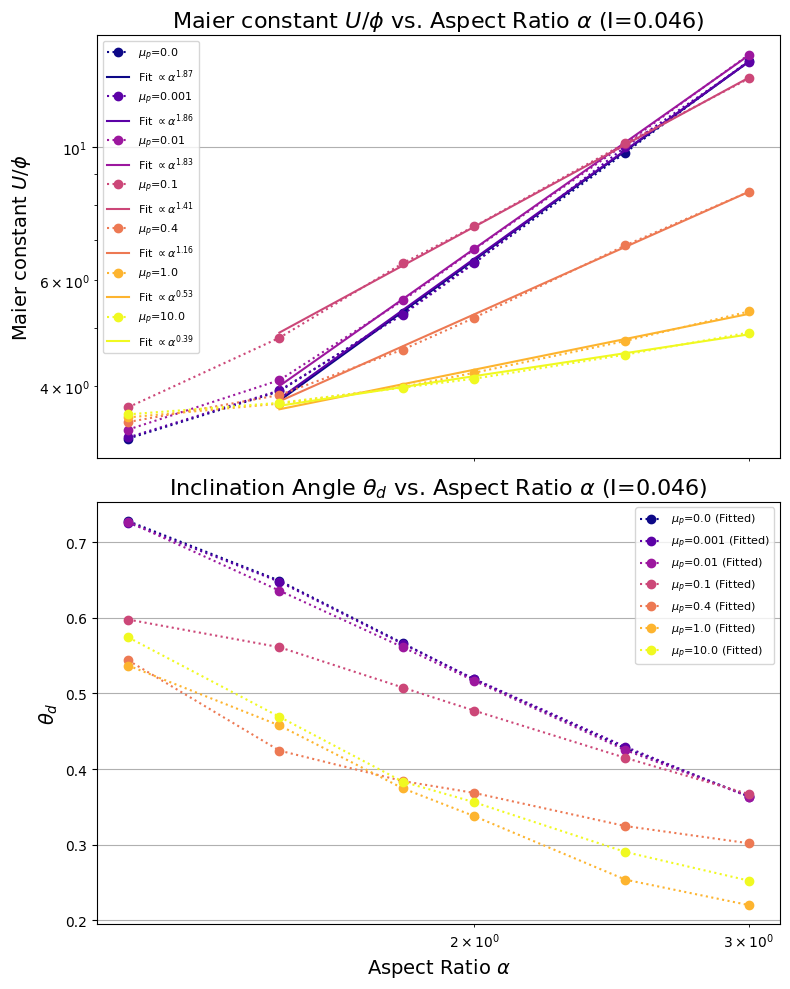

predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


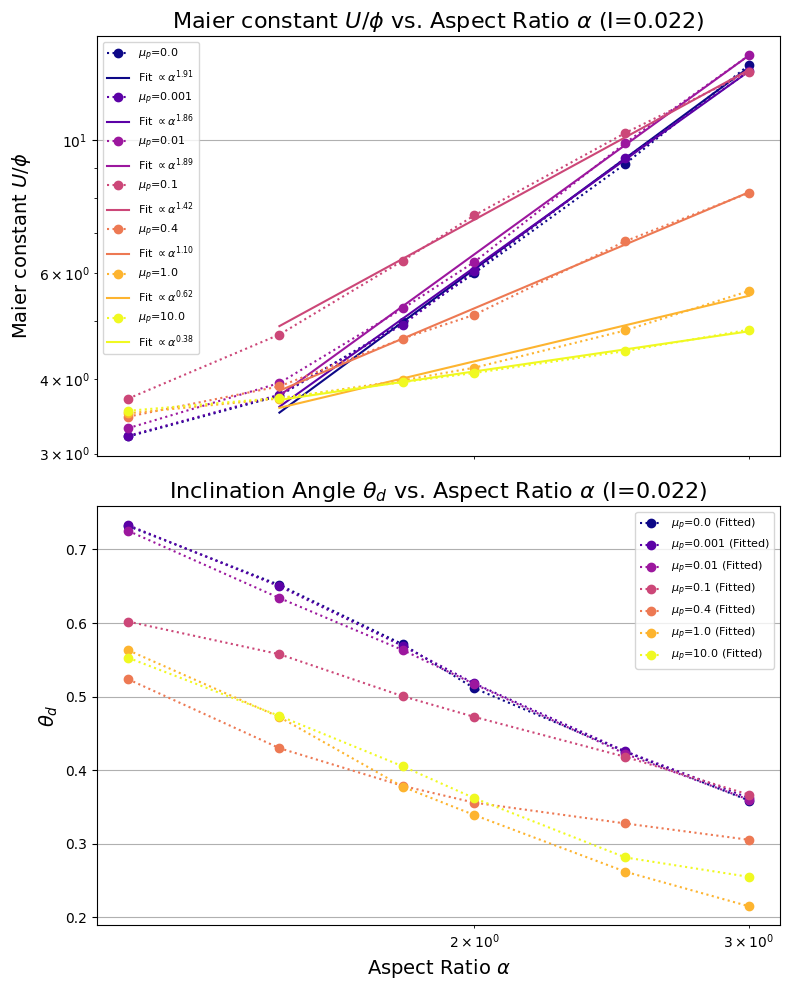

predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


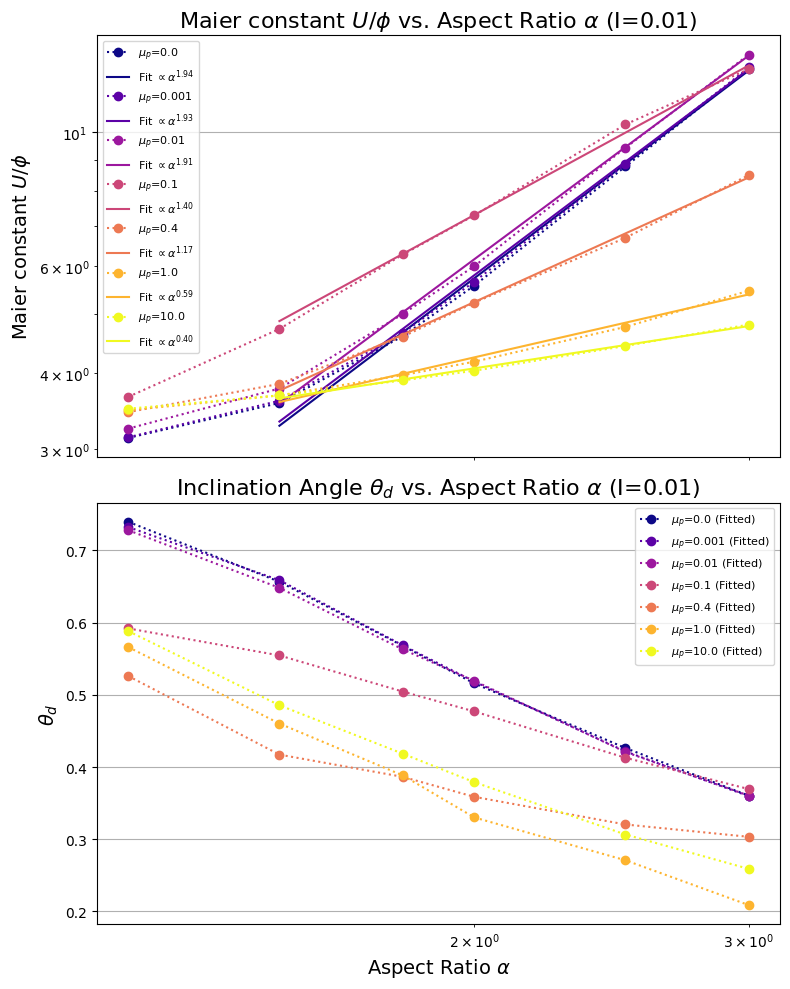

predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


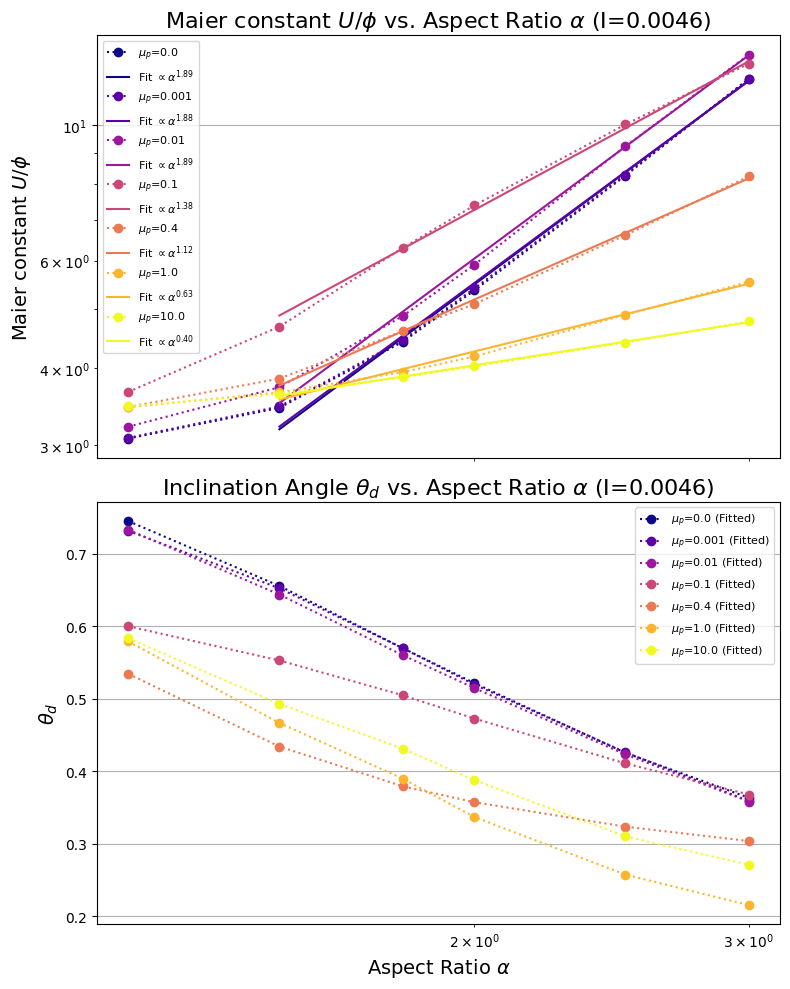

predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


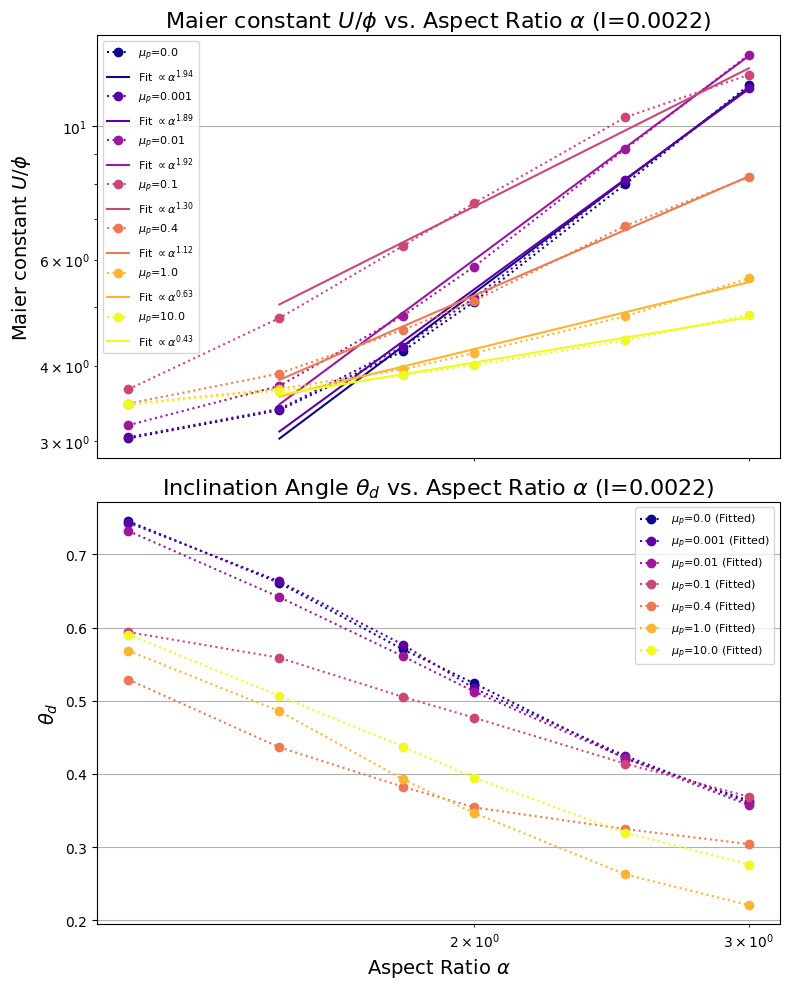

predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
predicted_theta_ds: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


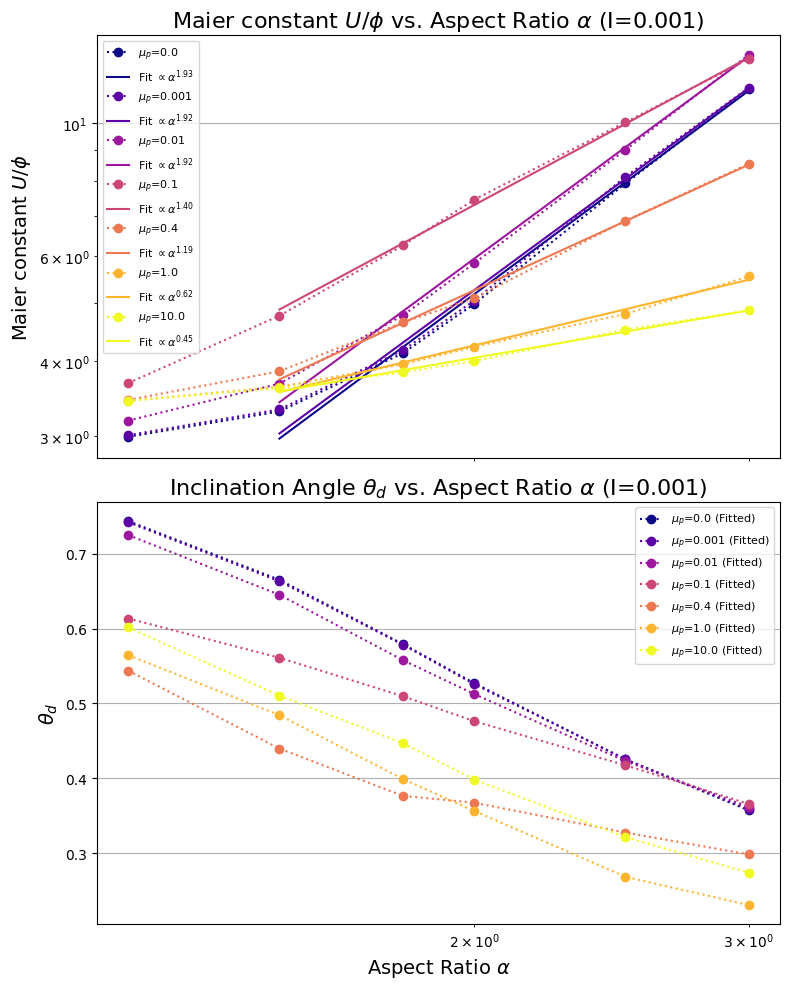

In [2]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt
import os
import pickle

# Define the function to fit
def fit_function(x, r, theta_d):
    """ Model function with r and theta_d as parameters. """
    numerator = np.exp(r * np.cos(2 * (x - theta_d)))
    
    # Compute denominator numerically
    denominator, _ = spi.quad(lambda t: np.exp(r * np.cos(2 * (t - theta_d))), -np.pi/2, np.pi/2)
    
    return numerator / denominator

# Define the values of mu_p (previously cof) and I to loop over
mu_p_values = [0.0, 0.001, 0.01, 0.1, 0.4, 1.0, 10.0]
I_values = [0.1, 0.046, 0.022, 0.01, 0.0046, 0.0022, 0.001]
alpha_values = [1.2, 1.5, 1.8, 2.0, 2.5, 3.0]
directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final/"

# Dictionary to store results for each mu_p and I
all_results = {}

# Loop over mu_p values
for mu_p in mu_p_values:
     
    all_results[mu_p] = {}
    
    # Loop over I values
    for I in I_values:
        actual_data = read_pdf_thetax(directory, mu_p, I, alpha_values)
        phis = read_data_key('phi', directory, mu_p, I, alpha_values)

        optimized_params = []

        # Optimize r and theta_d for each alpha
        for i, alpha in enumerate(alpha_values):
            actual_x, actual_p = actual_data[i]  # Extract data for this alpha
            
            # Perform the curve fitting
            initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
            popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)
            
            r = popt[0]
            theta_d = popt[1]
            
            # Compute U and rescale it by phi
            phi = phis[i]  # Get corresponding phi value
            x_fit = np.linspace(-np.pi/2, np.pi/2, 500)
            y_fit = fit_function(x_fit, r, theta_d)
            U = (r / np.trapezoid(np.cos(2 * (x_fit - theta_d)) * y_fit, x_fit)) / phi

            # Compute g(r)
            g_r = (np.trapezoid(np.exp(r * np.cos(2 * x_fit)), x_fit) / np.pi) ** 2

            # Compute beta and predicted theta
            beta = (alpha**2 - 1) / (alpha**2 + 1)
            predicted_theta = 0.5 * np.arccos(U / (r * beta) * (1 - 1 / g_r))
            
            # Store results
            optimized_params.append({
                'alpha': alpha,
                'r': r,
                'theta_d': theta_d,
                'U': U,
                'predicted_theta': predicted_theta
            })

        # Store results for this mu_p and I
        all_results[mu_p][I] = optimized_params
# -------------------------------------------------
# Create one figure per I, each with two subplots
# -------------------------------------------------
colormap = plt.cm.plasma  # Better colormap for perceptual clarity
colors = [colormap(i) for i in np.linspace(0, 1, len(mu_p_values))]

for I in I_values:
    fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
    
    # Plot U vs alpha
    for j, mu_p in enumerate(mu_p_values):
        results = all_results[mu_p][I]
        alphas = [result['alpha'] for result in results]
        Us = [result['U'] for result in results]
        axes[0].loglog(alphas, Us, 'o:', markersize=6, color=colors[j], label=f"$\\mu_p$={mu_p}")
        # starting from the second value of alpha, provide the best fit power law, with exponent
        # for the Maier constant U
        popt, _ = spo.curve_fit(lambda x, a, b: a * x**b, alphas[1:], Us[1:], p0=[1.0, 1.0])
        axes[0].loglog(alphas[1:], popt[0] * alphas[1:]**popt[1], '-', color=colors[j], label=f"Fit $\\propto \\alpha^{{{popt[1]:.2f}}}$")

    axes[0].set_ylabel('Maier constant $U / \\phi$', fontsize=14)
    axes[0].set_title(f'Maier constant $U / \\phi$ vs. Aspect Ratio $\\alpha$ (I={I})', fontsize=16)
    axes[0].grid(True)
    axes[0].legend(fontsize=8, loc='best')

        # Plot theta_d vs alpha
    for j, mu_p in enumerate(mu_p_values):
        results = all_results[mu_p][I]
        alphas = [result['alpha'] for result in results]
        theta_ds = [result['theta_d'] for result in results]
        predicted_theta_ds = [result['predicted_theta'] for result in results]  # Extract predicted theta values
        print(f"predicted_theta_ds: {predicted_theta_ds}")
        # Plot actual theta_d
        axes[1].plot(alphas, theta_ds, 'o:', markersize=6, color=colors[j], label=f"$\\mu_p$={mu_p} (Fitted)")
        
        # Plot predicted theta
        # axes[1].plot(alphas[1:], predicted_theta_ds[1:], 's--', markersize=5, color=colors[j], alpha=0.7, label=f"$\\mu_p$={mu_p} (Predicted)")

    axes[1].set_xlabel('Aspect Ratio $\\alpha$', fontsize=14)
    axes[1].set_ylabel('$\\theta_d$', fontsize=14)
    axes[1].set_title(f'Inclination Angle $\\theta_d$ vs. Aspect Ratio $\\alpha$ (I={I})', fontsize=16)
    axes[1].grid(True)
    axes[1].legend(fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()

# plot 


## Doi-Onsager model

Processing cof = 0.0


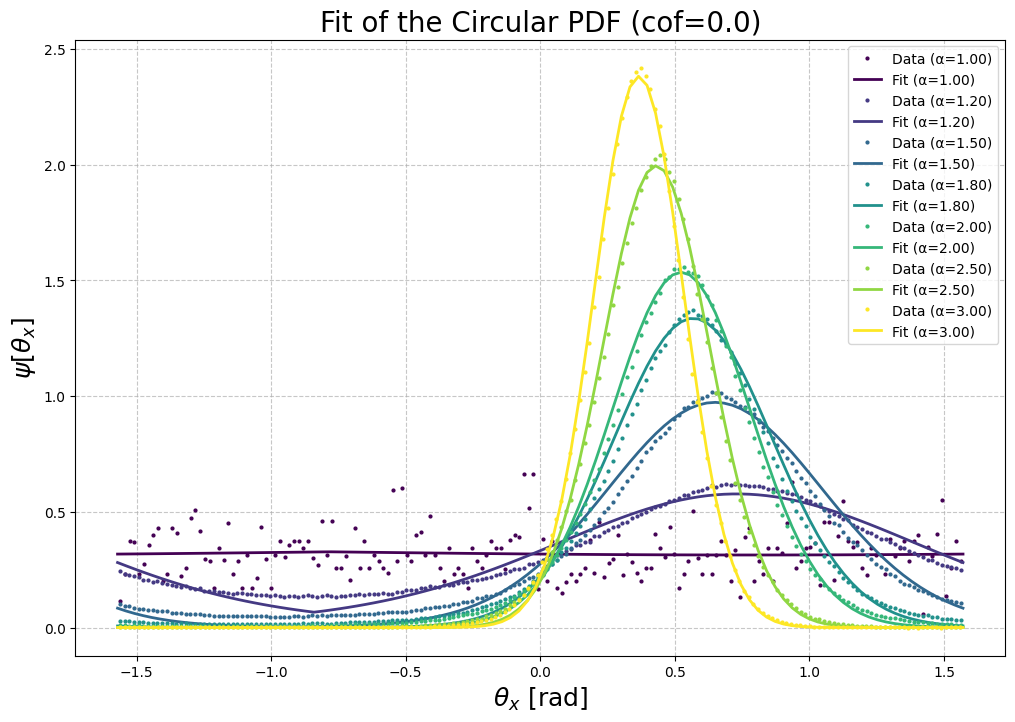

Processing cof = 0.001


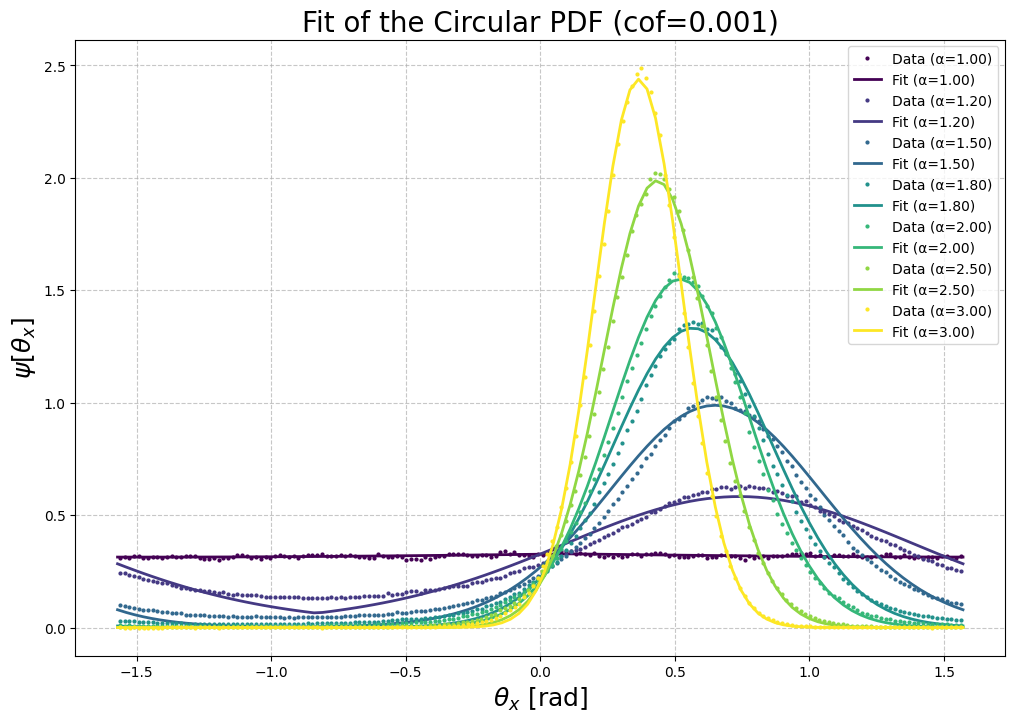

Processing cof = 0.01


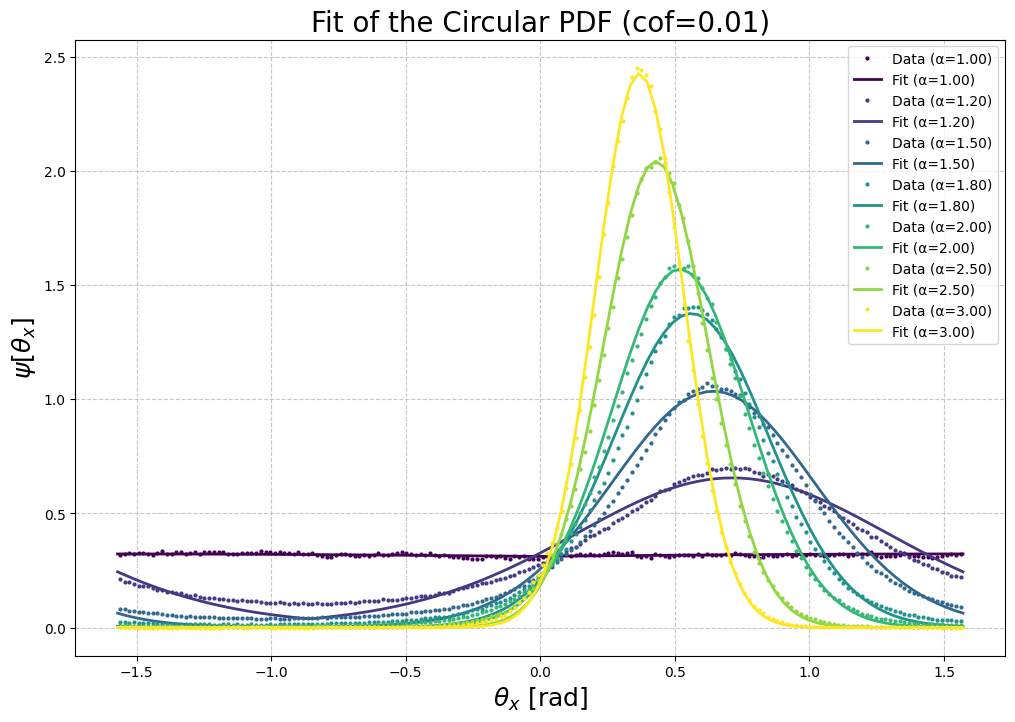

Processing cof = 0.1


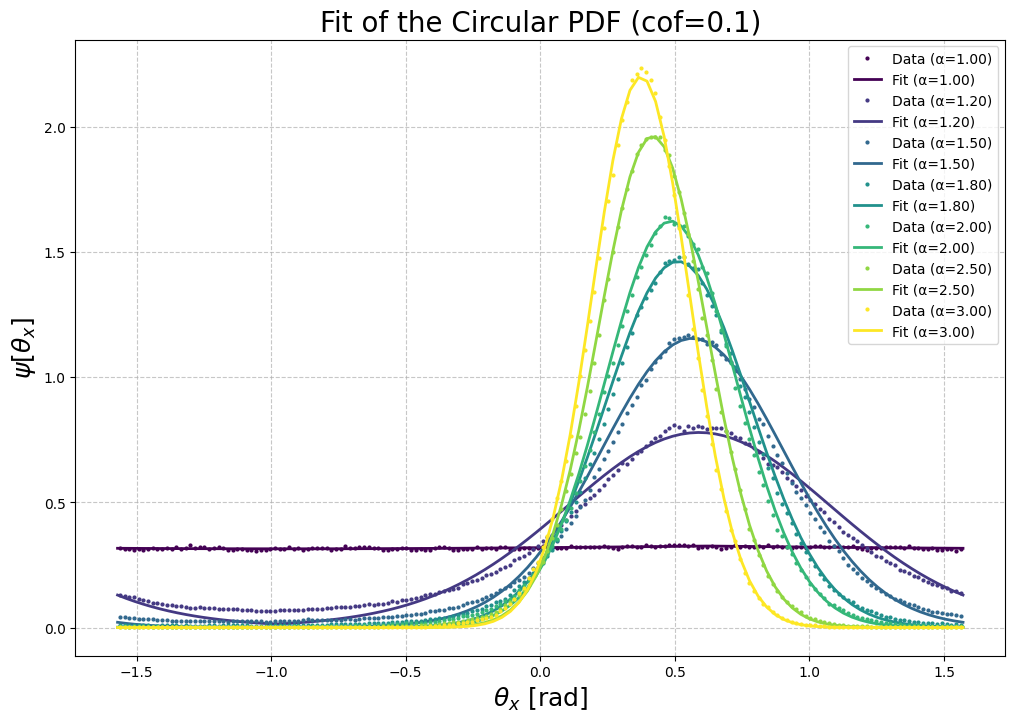

Processing cof = 0.4


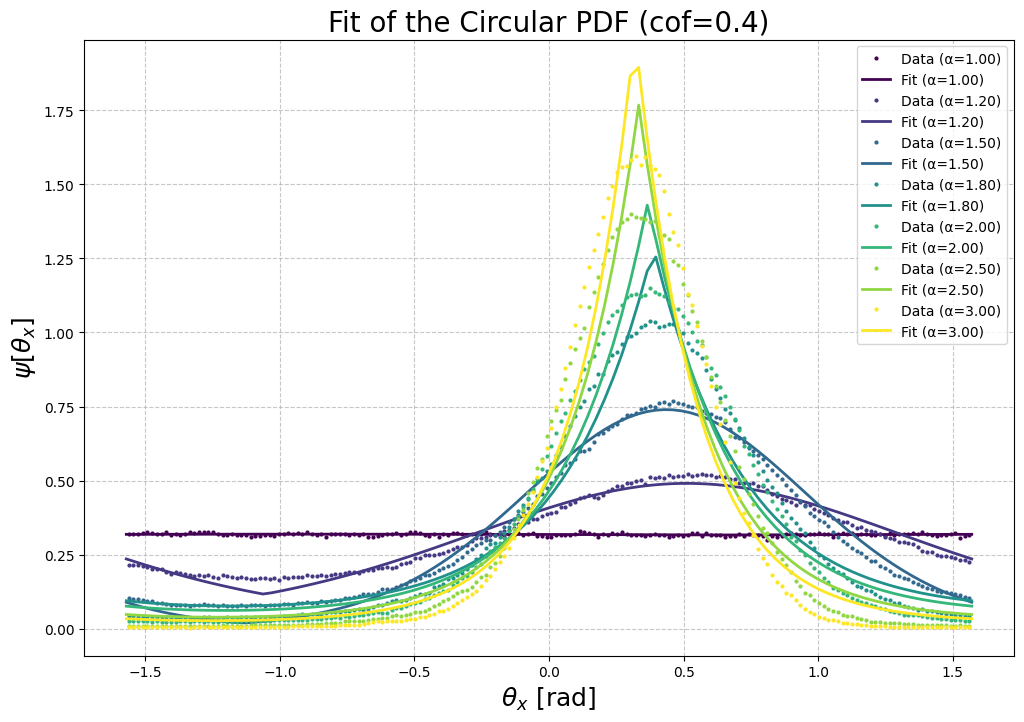

Processing cof = 1.0


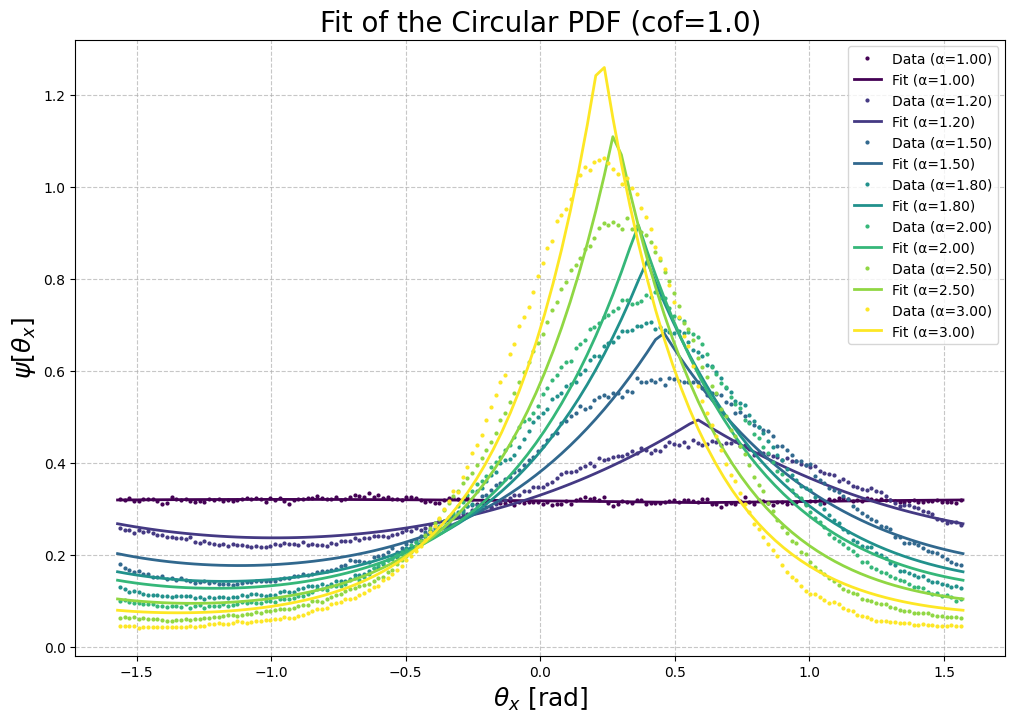

Processing cof = 10.0


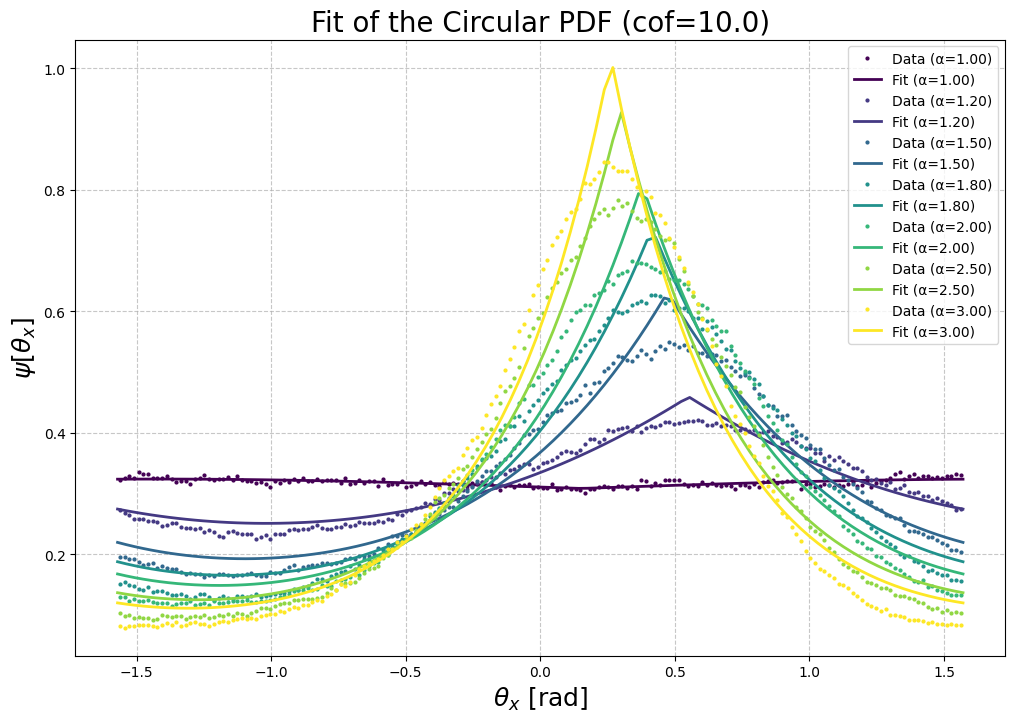

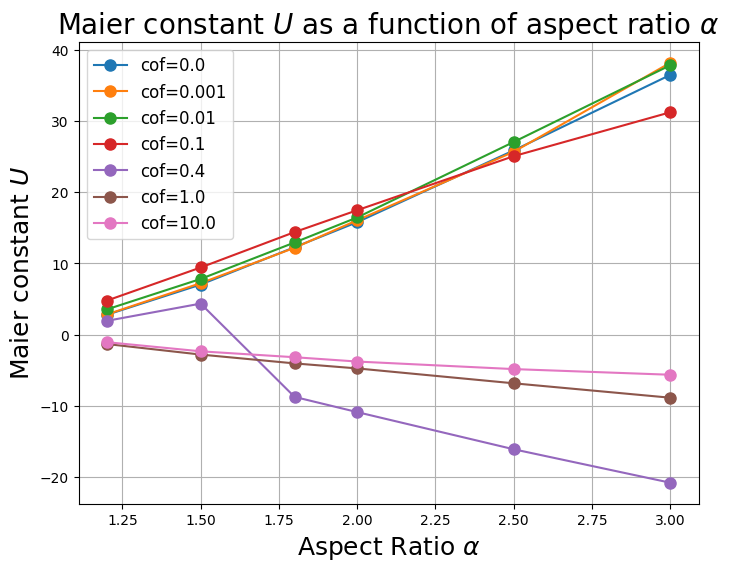

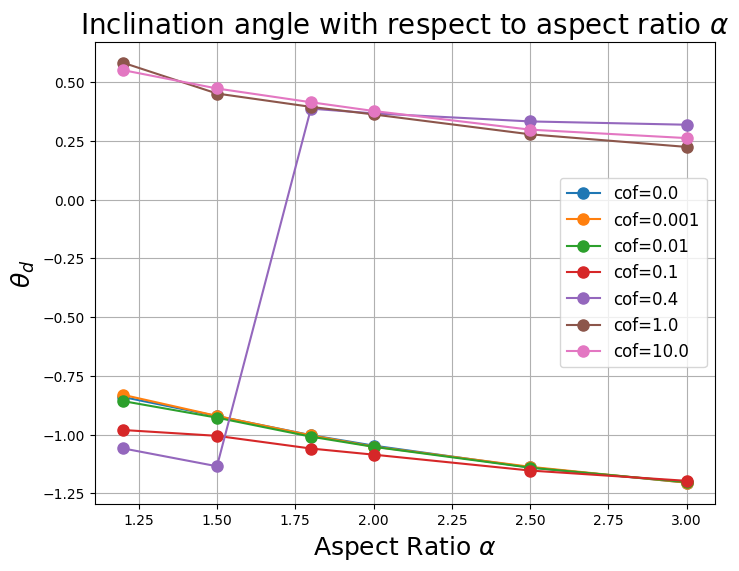

In [14]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt

from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pickle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools

# Define the function to fit
def fit_function(x, r, theta_d):
    """ Model function with r and theta_d as parameters. """
    numerator = np.exp(r * np.abs( np.sin( (x - theta_d))))
    
    # Compute denominator numerically
    denominator, _ = spi.quad(lambda t: np.exp(r * np.abs( np.sin((t - theta_d)))), -np.pi/2, np.pi/2)
    
    return numerator / denominator

# Define the values of cof to loop over
cofs = [0.0, 0.001, 0.01, 0.1, 0.4, 1.0, 10.0]
Is = [0.1, 0.046, 0.022, 0.01, 0.0046, 0.0022, 0.001]
alpha_values = [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]

# Dictionary to store results for each cof
all_results = {}

# Loop over cof values
for cof in cofs:
    print(f"Processing cof = {cof}")

    actual_data = read_pdf_thetax(directory, cof, I, alpha_values)

    optimized_params = []

    # Optimize r and theta_d for each alpha
    for i, alpha in enumerate(alpha_values):
        actual_x, actual_p = actual_data[i]  # Extract data for this alpha
        
        # Perform the curve fitting
        initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
        popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)
        
        r = popt[0]
        theta_d = popt[1]
        U = r / np.trapezoid(np.abs (np.sin((actual_x - theta_d))) * actual_p, actual_x)

        # Store results
        optimized_params.append({'alpha': alpha, 'r': r, 'theta_d': theta_d, 'U': U})

    # Store results for this cof
    all_results[cof] = optimized_params

    # Plot the actual data and fits for this cof
    plt.figure(figsize=(12, 8))
    colormap = plt.cm.viridis
    colors = [colormap(i) for i in np.linspace(0, 1, len(alpha_values))]

    for i, result in enumerate(optimized_params):
        alpha = result['alpha']
        r = result['r']
        theta_d = result['theta_d']
        
        # Generate model predictions
        x_fit = np.linspace(-np.pi/2, np.pi/2, 100)
        y_fit = fit_function(x_fit, r, theta_d)
        
        # Plot actual data
        actual_x, actual_p = actual_data[i]
        plt.plot(actual_x, actual_p, 'o', markersize=2, label=f"Data (α={alpha:.2f})", color=colors[i])
        
        # Plot fitted function
        plt.plot(x_fit, y_fit, '-', label=f"Fit (α={alpha:.2f})", color=colors[i], linewidth=2)

    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.title(f'Fit of the Circular PDF (cof={cof})', fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()

# Plot U vs alpha for all cofs in a single plot
plt.figure(figsize=(8, 6))

for cof, results in all_results.items():
    alphas = [result['alpha'] for result in results]
    Us = [result['U'] for result in results]
    plt.plot(alphas[1:], Us[1:], 'o-', markersize=8, label=f"cof={cof}")

plt.xlabel('Aspect Ratio $\\alpha$', fontsize=18)
plt.ylabel('Maier constant $U$', fontsize=18)
plt.title('Maier constant $U$ as a function of aspect ratio $\\alpha$', fontsize=20)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))

for cof, results in all_results.items():
    alphas = [result['alpha'] for result in results]
    theta_d = [result['theta_d'] for result in results]
    plt.plot(alphas[1:], theta_d[1:], 'o-', markersize=8, label=f"cof={cof}")

plt.xlabel('Aspect Ratio $\\alpha$', fontsize=18)
plt.ylabel('$\\theta_d$', fontsize=18)
plt.title('Inclination angle with respect to aspect ratio $\\alpha$', fontsize=20)
# plt.xlim(1.1, 3.1)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
